### Project: Computational models for robot-induced hallucinations in Parkinson’s Disease
### Laboratory of Cognitive Neuroscience - LNCO
### Author: Duarte Rodrigues
##### Script: This document is a test of the main functions that are used to calculate the motion features and different filtering methods. For this test a single participant data is analyzed at a time for the single-animal DLC.

##### It is not a continuous code where the last cell depends on all of the previous ones! If something specific was needed I added new cells just to do that task!

NOTE: Never forget that the results from the features are only as good and trustworthy as the DLC tracking. It will probably have jitter and other problems that of course will influence the features.

In [1]:
'''Main Library Imports'''
import motionAnalysisFX
import pandas as pd
import dlc2kinematics
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider,Button
import numpy as np
from scipy import signal
from IPython.display import display

In [ ]:
'''
FIRST! STANDARDIZE THE ENTIRE RESULTS FOLDER WITH ALL THE PARTICIPANTS!

In this cell you select the video that has the predictions done by DLC. It will get the frequency of sample based on the frame rate of the video,
as well as the .h5 data file with the predcitions (ideally already standardized). It should be in the same result directory as the video.

NOTE: When you run this cell, a new window opens to select the database folder with all the results. The new window
usually opens behind the code editor software.'''

from tkinter import Tk  
from tkinter.filedialog import askopenfilename
import cv2
import os
Tk().withdraw()
video_path = askopenfilename(title='Choose Labeled video', initialdir='D:\_users\Duarte_Projects') # show an "Open" dialog box and return the path to the selected file

cap=cv2.VideoCapture(video_path)
fs = cap.get(cv2.CAP_PROP_FPS)
directory=os.path.dirname(video_path)

for root, dirs, files in os.walk(directory):
    for name in files:
        if '.h5' in name:
            
            if 'skeleton' not in name and "standardized" in name:

                h5_path = directory + '/' + name
                print(h5_path)
                break
            elif 'skeleton' not in name:

                h5_path = directory + '/' + name
                print(h5_path)


In [3]:
''' If the data is already standadized it loads it. If not it will do that process first. '''
if "standardized" in h5_path:
    st_df, bodyparts, scorer = dlc2kinematics.load_data(h5_path) # Read the standardized data
else:
    df, bodyparts, scorer = dlc2kinematics.load_data(h5_path) # Read data
    st_df = motionAnalysisFX.standardize_df(df,bodyparts,scorer)
    display(st_df)

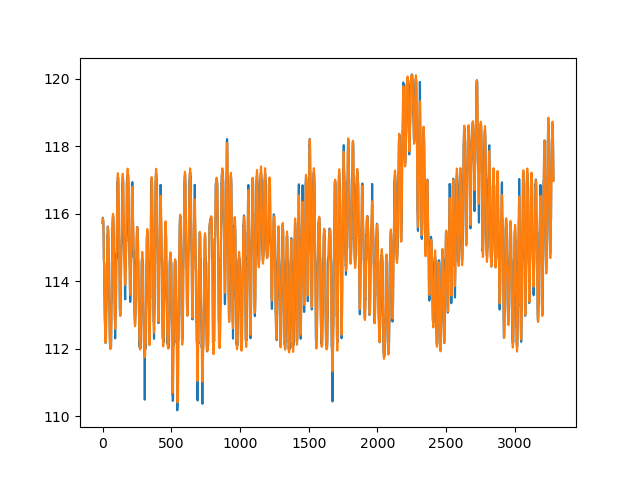

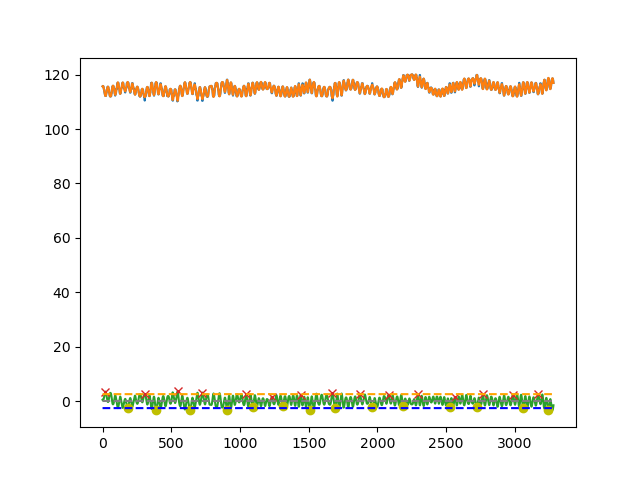

[0.9277879341864717, 115.00424097535117, 1.9018897116258393, 7.022504501330914, 5.138634125442058, 0.2417918907364889, 0.13107157953181287, 2.0754587656372987, 595.2365670964776]


In [5]:
'''Testing the get_features function'''
%matplotlib widget
li = motionAnalysisFX.get_features(st_df,fs,scorer,'finger1',participant_name="", plotting="True", angle="LL")
print(li)

In [ ]:
'''Testing the sanity_check function'''
%matplotlib widget
motionAnalysisFX.sanity_check(df,scorer,fs)
std_m = motionAnalysisFX.standard_metric(df)
print('The Standard Metric is '+str(np.round(std_m,2))+' pixels.')

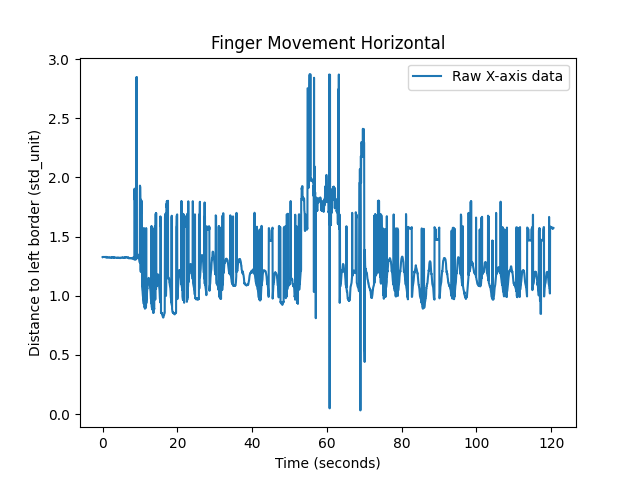

In [18]:
''' Plotting the raw movement of a specific body part - In the script is the finger!'''

# Determining based on the file name if it is the left (2) or right (1) finger
if os.path.basename(h5_path)[5] == 'L' or os.path.basename(h5_path)[6] == 'L':
    bodypart = 'finger2'
elif os.path.basename(h5_path)[5] == 'R' or os.path.basename(h5_path)[6] == 'R':
    bodypart = 'finger1'

parameter = 'x' # front and back

%matplotlib widget

# Plotting function
x_mov = st_df[scorer][bodypart][parameter]
time=motionAnalysisFX.time_list(x_mov,fs)

motionAnalysisFX.plot(time,x_mov, data_label='Raw X-axis data', x_label='Time (seconds)', y_label= 'Distance to left border (std_unit)')
plt.title('Finger Movement Horizontal')

plt.show()

d:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


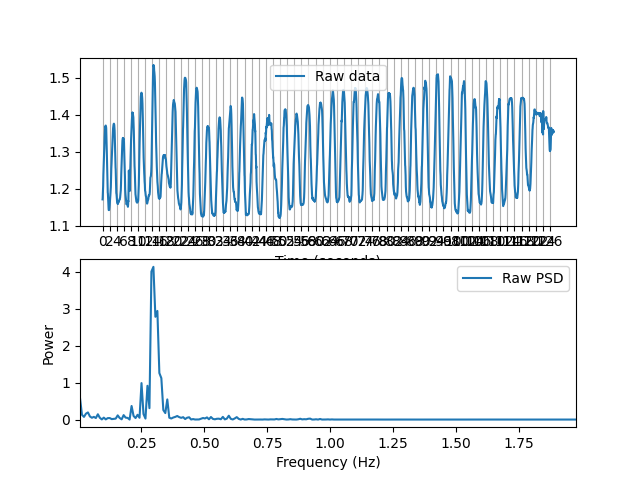

0.4491489361702127


In [5]:
''' Plotting the Power spectral density (PSD) and setting the cuttof by hand to see what is best'''
%matplotlib widget
psd, freq = motionAnalysisFX.PSD(x_mov, fs)
iii = np.where(psd == max(psd[20:])) # only works in good siganls
cutoff = freq[int(iii[0])] + 1.5 # what is the frequency most proeminent in the signal

if cutoff < 1.4:
    cutoff = 1.5

print(cutoff)


## Movement filtering and saving new values in filt_df

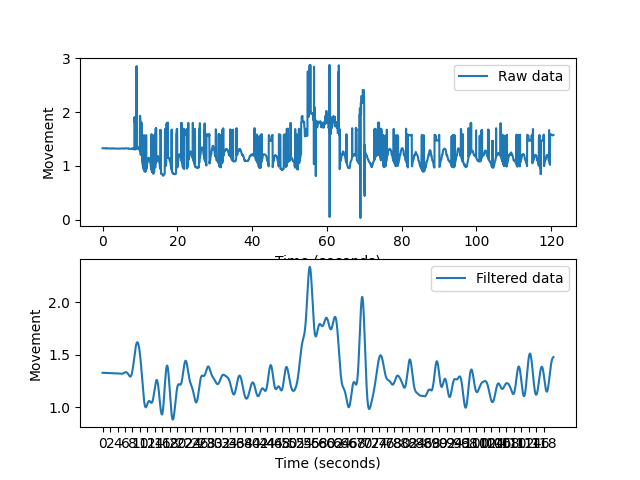

(3619,)
1.2924133495995906


In [19]:
''' In this cell the order was experiemented, as well as getting the best cuttoff freq possible based on the PSD'''
%matplotlib widget
filt = motionAnalysisFX.LowPassFilter(x_mov,fs,cutoff,5,application='Movement')

print(x_mov.shape)
print(np.mean(filt))

In [20]:
''' Showing the difference between the original and filtered df, to verify it saved correctly. Here we are just changing the finger1 values of x.'''
display(st_df)
filt_df = st_df
for ind in range(st_df.shape[0]):
    filt_df.iloc[ind][scorer, bodypart, parameter] = filt[ind]
display(filt_df)

scorer    DLC_resnet101_LL_Correct_CropMay16shuffle1_175000            \
bodyparts                                           finger1             
coords                                                    x         y   
0                                                  1.313271  1.455999   
1                                                  1.315285  1.457677   
2                                                  1.315586  1.457333   
3                                                  1.314725  1.457329   
4                                                  1.314141  1.459580   
...                                                     ...       ...   
3614                                               2.144816  2.354185   
3615                                               2.144539  2.353615   
3616                                               2.148884  2.355872   
3617                                               2.147395  2.352384   
3618                                               2.149754  2.353573   

scorer                                                                   \
bodyparts               wrist1                         elbow1             
coords    likelihood         x         y likelihood         x         y   
0           0.368116  2.474525  2.117103   0.999994  1.281632  1.486216   
1           0.196091  2.466922  2.122432   0.999994  1.281758  1.486666   
2           0.232440  2.466822  2.122273   0.999993  1.281613  1.486998   
3           0.160620  2.467461  2.123015   0.999993  1.281899  1.486154   
4           0.316309  2.469304  2.121223   0.999993  1.281751  1.486444   
...              ...       ...       ...        ...       ...       ...   
3614        0.999971  2.488157  2.122185   0.999997  2.720481  1.653026   
3615        0.999962  2.487756  2.121698   0.999997  2.725370  1.651443   
3616        0.999963  2.487111  2.122591   0.999997  2.721784  1.637446   
3617        0.999972  2.487731  2.121656   0.999997  2.726961  1.655316   
3618        0.999968  2.486528  2.122290   0.999996  2.719091  1.640946   

scorer                          ...                                  \
bodyparts            shoulder1  ... robot_joint robot_top             
coords    likelihood         x  ...  likelihood         x         y   
0           0.003370  0.032904  ...    1.000000  0.337132  0.761766   
1           0.003350  0.032334  ...    1.000000  0.334130  0.761613   
2           0.003249  0.032410  ...    1.000000  0.334527  0.761430   
3           0.003477  0.032613  ...    1.000000  0.333418  0.761345   
4           0.003222  0.033063  ...    1.000000  0.333695  0.761289   
...              ...       ...  ...         ...       ...       ...   
3614        0.002433  0.026812  ...    1.000000  0.349364  0.765373   
3615        0.002003  3.442930  ...    0.999999  0.350370  0.765580   
3616        0.001928  0.026773  ...    0.999999  0.349849  0.766094   
3617        0.002082  2.855858  ...    0.999999  0.350589  0.765235   
3618        0.002350  2.855835  ...    0.999999  0.350121  0.765011   

scorer                                                                     \
bodyparts            robot_base                      robot_logo             
coords    likelihood          x         y likelihood          x         y   
0           0.999990   0.208961  1.761434   0.999932   0.265826  1.019048   
1           0.999990   0.210988  1.761789   0.999923   0.266230  1.019402   
2           0.999990   0.211497  1.761868   0.999918   0.266104  1.019311   
3           0.999991   0.207541  1.761362   0.999917   0.266114  1.019580   
4           0.999991   0.207692  1.761800   0.999921   0.266239  1.018833   
...              ...        ...       ...        ...        ...       ...   
3614        0.999923   0.216877  1.770890   0.999297   0.251908  1.007812   
3615        0.999930   0.226855  1.772389   0.999329   0.253263  1.007745   
3616        0.999929   0.215612  1.770493   0.999302   0.254190  1.009105   
3617   

scorer    DLC_resnet101_LL_Correct_CropMay16shuffle1_175000            \
bodyparts                                           finger1             
coords                                                    x         y   
0                                                  1.313271  1.455999   
1                                                  1.315285  1.457677   
2                                                  1.315586  1.457333   
3                                                  1.314725  1.457329   
4                                                  1.314141  1.459580   
...                                                     ...       ...   
3614                                               2.144816  2.354185   
3615                                               2.144539  2.353615   
3616                                               2.148884  2.355872   
3617                                               2.147395  2.352384   
3618                                               2.149754  2.353573   

scorer                                                                   \
bodyparts               wrist1                         elbow1             
coords    likelihood         x         y likelihood         x         y   
0           0.368116  2.474525  2.117103   0.999994  1.281632  1.486216   
1           0.196091  2.466922  2.122432   0.999994  1.281758  1.486666   
2           0.232440  2.466822  2.122273   0.999993  1.281613  1.486998   
3           0.160620  2.467461  2.123015   0.999993  1.281899  1.486154   
4           0.316309  2.469304  2.121223   0.999993  1.281751  1.486444   
...              ...       ...       ...        ...       ...       ...   
3614        0.999971  2.488157  2.122185   0.999997  2.720481  1.653026   
3615        0.999962  2.487756  2.121698   0.999997  2.725370  1.651443   
3616        0.999963  2.487111  2.122591   0.999997  2.721784  1.637446   
3617        0.999972  2.487731  2.121656   0.999997  2.726961  1.655316   
3618        0.999968  2.486528  2.122290   0.999996  2.719091  1.640946   

scorer                          ...                                  \
bodyparts            shoulder1  ... robot_joint robot_top             
coords    likelihood         x  ...  likelihood         x         y   
0           0.003370  0.032904  ...    1.000000  0.337132  0.761766   
1           0.003350  0.032334  ...    1.000000  0.334130  0.761613   
2           0.003249  0.032410  ...    1.000000  0.334527  0.761430   
3           0.003477  0.032613  ...    1.000000  0.333418  0.761345   
4           0.003222  0.033063  ...    1.000000  0.333695  0.761289   
...              ...       ...  ...         ...       ...       ...   
3614        0.002433  0.026812  ...    1.000000  0.349364  0.765373   
3615        0.002003  3.442930  ...    0.999999  0.350370  0.765580   
3616        0.001928  0.026773  ...    0.999999  0.349849  0.766094   
3617        0.002082  2.855858  ...    0.999999  0.350589  0.765235   
3618        0.002350  2.855835  ...    0.999999  0.350121  0.765011   

scorer                                                                     \
bodyparts            robot_base                      robot_logo             
coords    likelihood          x         y likelihood          x         y   
0           0.999990   0.208961  1.761434   0.999932   0.265826  1.019048   
1           0.999990   0.210988  1.761789   0.999923   0.266230  1.019402   
2           0.999990   0.211497  1.761868   0.999918   0.266104  1.019311   
3           0.999991   0.207541  1.761362   0.999917   0.266114  1.019580   
4           0.999991   0.207692  1.761800   0.999921   0.266239  1.018833   
...              ...        ...       ...        ...        ...       ...   
3614        0.999923   0.216877  1.770890   0.999297   0.251908  1.007812   
3615        0.999930   0.226855  1.772389   0.999329   0.253263  1.007745   
3616        0.999929   0.215612  1.770493   0.999302   0.254190  1.009105   
3617   

#### Now that the process is understood the same can be applied and computed for Y

d:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


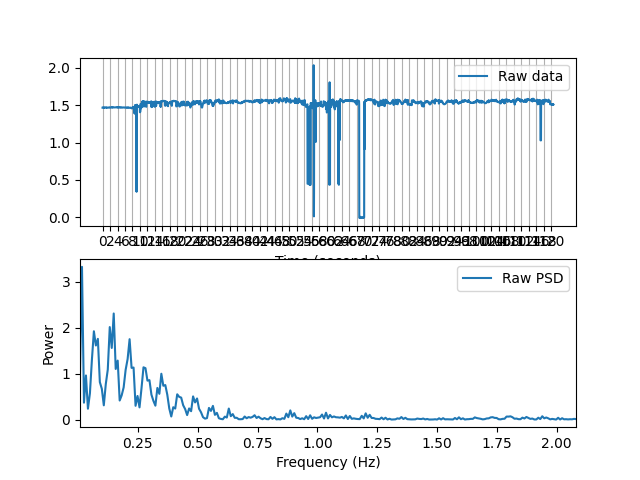

0.3655291516993645


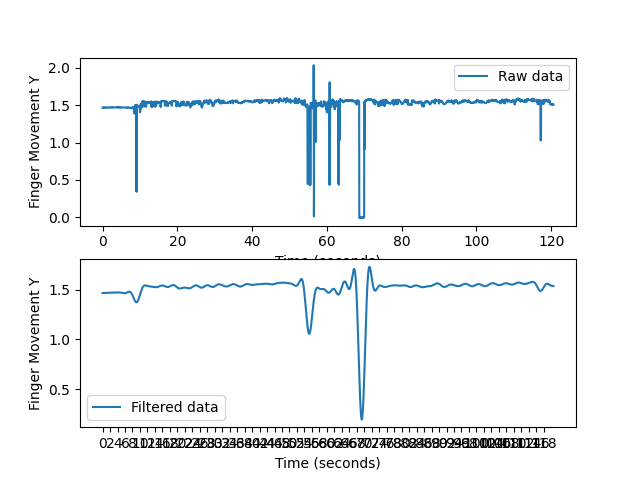

In [21]:
# Movement in Y axis
y_mov = st_df[scorer][bodypart]['y'] #raw signal

#Getting the PSD and the most prominent frequency to establish the cuttoff
psd, freq = motionAnalysisFX.PSD(y_mov, fs,plotting=True)
iii = np.where(psd == max(psd[20:]))
cutoff = freq[int(iii[0])] + 1.5

if cutoff < 1.4:
    cutoff = 1.5  
print(cutoff)

# Writing in the filtered df the new values for the finger at Y
filt_mov_y = motionAnalysisFX.LowPassFilter(y_mov,fs,cutoff,5,application='Finger Movement Y')
for ind in range(filt_df.shape[0]):
    filt_df.iloc[ind][scorer, bodypart, 'y'] = filt_mov_y[ind]
    
display(filt_df)

In [12]:
# The objective is for the SNR to be as large as possible... however this does not mean it fits the data

# Comparing the values of the SNR between the raw and filtered signals
print(motionAnalysisFX.signaltonoise(x_mov))
print(motionAnalysisFX.signaltonoise(filt))

# It is a very inconsistent measure!!

11.42600714274654
11.971072310449486


In [ ]:
# Use the next function to see what is the best window for the Savitsky Golay filter - Trial and error
# It is impossible to get a window that works on all the participants
motionAnalysisFX.SavGolWindow(x_mov,30,101,2)

In [ ]:
#Write the best window value from the plot above
%matplotlib widget
filt_x_mov = signal.savgol_filter(x_mov, 173, 2)
plt.plot(filt_x_mov)
print(motionAnalysisFX.signaltonoise(filt_x_mov))
plt.show()

### Compute the velocity (first derivative of the movement component)

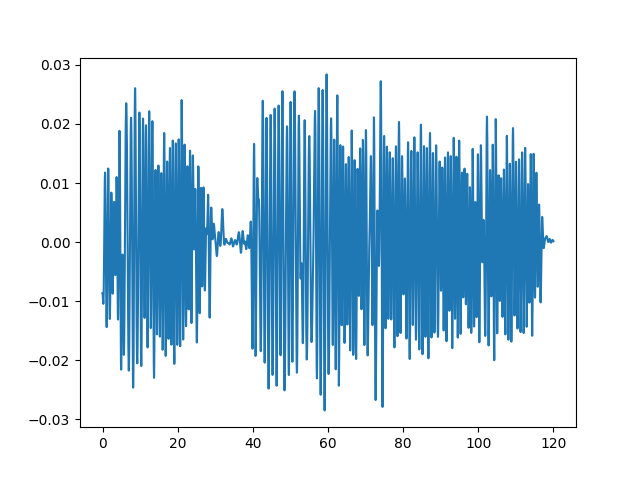

In [110]:
# Note that the velocity is divided into X and Y ('parameter' argument) - the velocity can be negative
vel_finger_x = motionAnalysisFX.velocity(filt_df,bodypart,scorer,parameter)
%matplotlib widget
t = motionAnalysisFX.time_list(vel_finger_x,fs)
plt.plot(t, vel_finger_x)

plt.show()

In [ ]:
# Getting the PSD of the velocity
%matplotlib widget
motionAnalysisFX.PSD(vel_finger_x, fs)

In [ ]:
# Application of the lowPass to see the effect on the velocity
%matplotlib widget
motionAnalysisFX.LowPassFilter(vel_finger_x,fs,.5,2,application='Velocity') # this works pretty good fro velocity x

In [ ]:
# Application of the Savinstky Golay to see the effect on the velocity
%matplotlib widget
motionAnalysisFX.SavGolWindow(vel_finger_x,fs,41,2)

In [ ]:
#Write the best window value from the plot above
%matplotlib widget
filt_x_vel = signal.savgol_filter(vel_finger_x, 31, 2)
t=motionAnalysisFX.time_list(filt_x_vel,fs)

plt.plot(t,filt_x_vel)
plt.show()

## Compute Speed

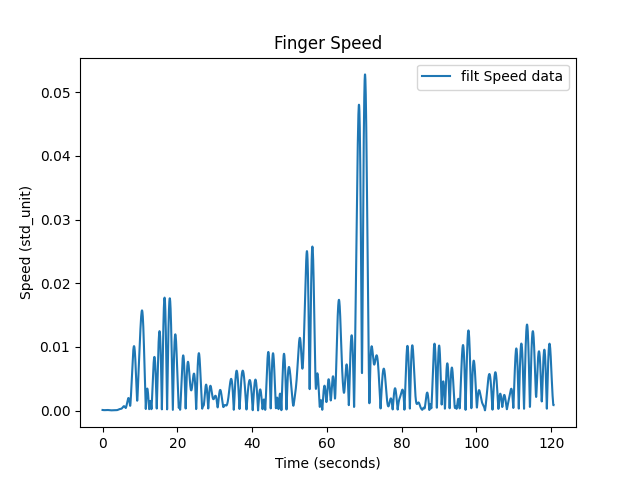

In [22]:
# Note that the speed has both X and Y components together - there is no negative speed

# Calculate the speed based on the filtered DF
speed_finger = motionAnalysisFX.speed(filt_df, bodypart, scorer, fs)
t = motionAnalysisFX.time_list(speed_finger,fs)

# Calculate the speed based on the raw DF
speed_fingerr = motionAnalysisFX.speed(st_df, bodypart, scorer, fs)
tr = motionAnalysisFX.time_list(speed_fingerr,fs)

#Plotting to compare the signal when calculated from the raw VS filtered data
%matplotlib widget
fig, axs = plt.subplots(2,1)


plt.sca(axs[0])
motionAnalysisFX.plot(t,speed_finger, data_label='filt Speed data', x_label='Time (seconds)', y_label= 'Speed (std_unit)')
plt.title('Finger Speed Filt')

plt.sca(axs[1])
motionAnalysisFX.plot(tr,speed_fingerr, data_label='Raw Speed data', x_label='Time (seconds)', y_label= 'Speed (std_unit)')
plt.title('Finger Speed Raw')


plt.show()

In [ ]:
# Comparing the values of the SNR of the speed signals (Raw vs Filt)
print(motionAnalysisFX.signaltonoise(speed_fingerr)) #raw
print(motionAnalysisFX.signaltonoise(speed_finger)) #filt


d:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


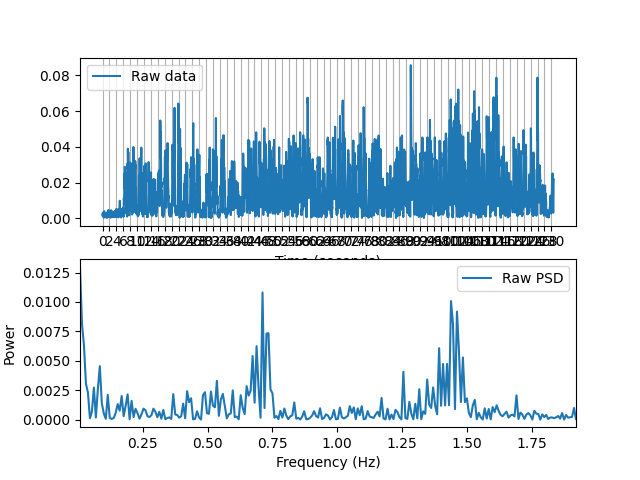

In [53]:
# PSD of the speed to get the best cutoff
%matplotlib widget
motionAnalysisFX.PSD(speed_finger, fs)

In [ ]:
# Low pass of the speed signal based on the already filtered data
%matplotlib widget
yu=motionAnalysisFX.LowPassFilter(speed_finger,fs,.75,5,application='Speed')

In [ ]:
motionAnalysisFX.SavGolWindow(speed_finger,fs,41,2)

In [ ]:
''' Since the point is to reduce high frequency variations (noise) in order to smoothen the signal, the median filter was also tried!'''
import scipy

# Result from the median filter
res = scipy.ndimage.median_filter(speed_finger,size=int(fs))
t = motionAnalysisFX.time_list(res,fs)

# Plotting
%matplotlib widget
plt.plot(t, res)
plt.show()

In [ ]:
# Getting the PSD of the result of the median
%matplotlib widget
motionAnalysisFX.PSD(res, fs)

In [ ]:
# Application of the lowPass in combination with the median to see if it works better
%matplotlib widget
motionAnalysisFX.LowPassFilter(res,fs,.5,5,application='Speed')

### Compute the Acceleration (second derivative of the movement component)

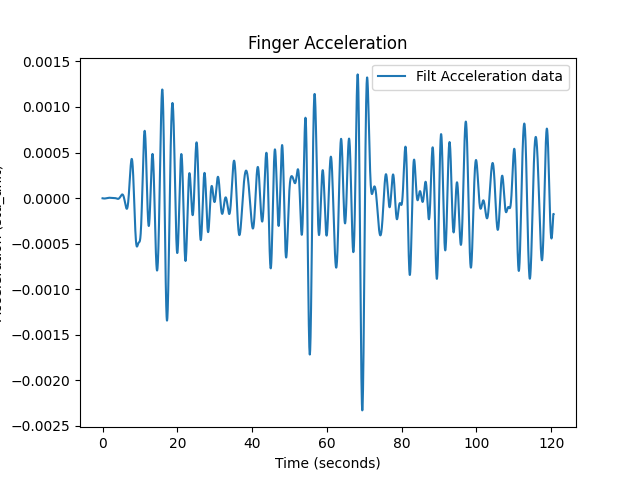

In [23]:
# Computing the acceleration based ont eh filtered data
accel_finger=motionAnalysisFX.accel(filt_df, bodypart, scorer, parameter)
t = motionAnalysisFX.time_list(accel_finger,fs)

%matplotlib widget
motionAnalysisFX.plot(t,accel_finger, data_label='Filt Acceleration data', x_label='Time (seconds)', y_label= 'Acceleration (std_unit)')
plt.title('Finger Acceleration')
plt.show()

''' The second derivative increases the magnitude of the noise exponentially, leaving the actual signal imperceptible. No valueable information can be extracted from the accelerarion since we dont know if it is noise.'''